In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [10]:
def GS2dict():
    # Google API stuff
    scope = ["https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name('config/gcp-credentials.json', scope)
    client = gspread.authorize(creds)
    runs = ['run2', 'run3', 'run4', 'run5', 'run6']
    D = defaultdict(lambda: [])
    for run in runs:
        sheet = client.open('results_layers').worksheet(run)
        df = pd.DataFrame(sheet.get_all_records())
        D['SST2'].append(list(df['SST2'])) 
        D['QQP'].append(list(df['QQP']))
        D['MNLI'].append(list(df['MNLI']))
    for key in D.keys():
        D[key] = np.array(D[key]).transpose() #transpose
    return D

In [11]:
D = GS2dict()

In [12]:
stds, means = {}, {}
for key in D.keys():
    stds[key] = np.std(D[key], axis=1)
    #stds[key] = 0.02 + np.random.rand(13) * 0.02
    means[key] = np.mean(D[key], axis=1)

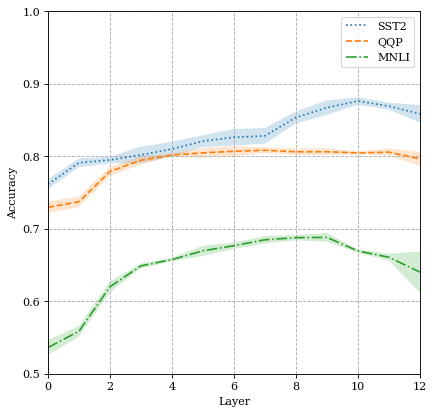

In [14]:
x = list(range(0, 13))
style = {'SST2': ':', 'MNLI': '-.', 'QQP': '--'}
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams["font.family"] = "serif"
for key in D.keys():
    plt.plot(x, means[key], style[key], label=key)
    plt.fill_between(x, means[key] + stds[key], means[key] - stds[key], alpha=0.2)
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Layer')
plt.grid(linestyle='--')
fig.axes[0].set_xlim([0, 12])
fig.axes[0].set_ylim([0.5, 1.0])
plt.savefig('figures/test.png')

In [16]:
x = list(range(0, 13))
y = 
error = np.random.normal(0.1, 0.02, size=y.shape)
y += np.random.normal(0, 0.1, size=y.shape)

plt.plot(x, y, 'k-')
plt.fill_between(x, y-error, y+error)
plt.show()

SyntaxError: invalid syntax (<ipython-input-16-e0e325a81e55>, line 2)

ValueError: invalid literal for int() with base 10: 'f'

In [28]:
D = defaultdict(lambda: [])


[]